In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from functools import reduce as func_reduce
from operator import mul as op_mul
from os import cpu_count

#This class contains DatasetClass and several helper functions
import ClassModule as cm

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
sns.set()

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cuda:0


In [3]:
pin_memory = True
non_blocking = True
set_to_none = True
torch.backends.cudnn.benchmark = True
INSTANCE_NOISE = False
worker_cores = 4

In [4]:
### Add Instance Noise to training image, can improve training
# https://arxiv.org/abs/1610.04490
def add_instance_noise(data, std=0.1):
    return data + 0.001 * torch.distributions.Normal(0, std).sample(data.shape)

## Load data from files

In [5]:
# Function for loading data for normalization from file
def load_Normalization_Data(path='Data/normalization.npz'):
    data = np.load(path, allow_pickle=True)

    maxData = { 'maxCellEnergy' : data['maxCellEnergy'], 'maxCellTiming' : data['maxCellTiming']
               ,'maxClusterE' : data['maxClusterE'], 'maxClusterPt' : data['maxClusterPt']
               ,'maxClusterM20' : data['maxClusterM20'], 'maxClusterM02' : data['maxClusterM02']
               ,'maxClusterDistFromVert' : data['maxClusterDistFromVert'], 'maxPartE' : data['maxPartE']
               ,'maxPartPt' : data['maxPartPt'], 'maxPartEta' : data['maxPartEta'], 'maxPartPhi' : data['maxPartPhi'] }

    minData = { 'minCellEnergy' : data['minCellEnergy'], 'minCellTiming' : data['minCellTiming']
               ,'minClusterE' : data['minClusterE'], 'minClusterPt' : data['minClusterPt']
               ,'minClusterM20' : data['minClusterM20'], 'minClusterM02' : data['minClusterM02']
               ,'minClusterDistFromVert' : data['minClusterDistFromVert'], 'minPartE' : data['minPartE']
               ,'minPartPt' : data['minPartPt'], 'minPartEta' : data['minPartEta'], 'minPartPhi' : data['minPartPhi'] }

    return minData, maxData

In [6]:
# Implementation of pytorch dataset class, loads the full dataset
# into ram. Can be used for datapreprocessing and augmentation.
# Check the pytorch documentation for detailed instructions on setting up a
# dataset class
class ClusterDataset_Full(utils.Dataset):
    """Cluster dataset."""
    # Initialize class and load data
    def __init__(self, npz_file, Normalize=True, arrsize=20):
        """
        Args:
            npz_file (string): Path to the npz file.
        """
        self.data = np.load(npz_file, allow_pickle=True)
        self.arrsize = arrsize
        self.ClusterN = self.data['ClusterN']
        self.Cluster = self.data['Cluster']
        self.ClusterTiming = self.data['ClusterTiming']
        self.ClusterType = self.data['ClusterType']
        self.ClusterE = self.data['ClusterE']
        self.ClusterPt = self.data['ClusterPt']
        self.ClusterModuleNumber = self.data['ClusterModuleNumber']
        self.ClusterCol = self.data['ClusterCol']
        self.ClusterRow = self.data['ClusterRow']
        self.ClusterM02 = self.data['ClusterM02']
        self.ClusterM20 = self.data['ClusterM20']
        self.ClusterDistFromVert = self.data['ClusterDistFromVert']
        self.PartE = self.data['PartE']
        self.PartPt = self.data['PartPt']
        self.PartEta = self.data['PartEta']
        self.PartPhi = self.data['PartPhi']
        self.PartIsPrimary = self.data['PartIsPrimary']
        self.PartPID = self.data['PartPID']
        self.Normalize = Normalize
        if self.Normalize:
            self.minData, self.maxData = load_Normalization_Data()

    # Return size of dataset
    def __len__(self):
        return self.data["Size"]

    # Routine for reconstructing clusters from given cell informations
    def __ReconstructCluster(self, ncell, modnum, row, col, cdata):
        _row = row.copy()
        _col = col.copy()
        if not np.all( modnum[0] == modnum[:ncell]):
            ModNumDif = modnum - np.min(modnum[:ncell])
            mask = np.where(ModNumDif == 1)
            _col[mask] += 48
            mask = np.where(ModNumDif == 2)
            _row[mask] += 24
            mask = np.where(ModNumDif == 3)
            _row[mask] += 24
            _col[mask] += 48

        arr = np.zeros(( self.arrsize, self.arrsize ), dtype=np.float32)

        col_min = np.min(_col[:ncell])
        row_min = np.min(_row[:ncell])
        width = np.max(_col[:ncell]) - col_min
        height = np.max(_row[:ncell]) - row_min
        offset_h = int((self.arrsize-height)/2)
        offset_w = int((self.arrsize-width)/2)

        for i in range(ncell):
            arr[ _row[i] - row_min + offset_h, _col[i] - col_min + offset_w ] = cdata[i]
        return arr

    # Function for merging the timing and energy information into one 'picture'
    def __GetCluster(self, ncell, modnum, row, col, energy, timing):
        cluster_e = self.__ReconstructCluster(ncell, modnum, row, col, energy)
        cluster_t = self.__ReconstructCluster(ncell, modnum, row, col, timing)
        return np.stack([cluster_e, cluster_t], axis=0)

    # One-hot encoding for the particle code
    def __ChangePID(self, PID):
        if (PID != 111) & (PID != 221):
            PID = np.int16(0)
        if PID == 111:
            PID = np.int16(1)
        if PID == 221:
            PID = np.int16(2)
        return PID

    # If normalize is true return normalized feature otherwise return feature
    # Also adjusts the dimension to 1d-array if feature is scalar
    def __Normalize(self, feature, min, max):
        feature = np.atleast_1d(feature)
        if self.Normalize:
            return self.__Norm01(feature, min, max)
        else:
            return feature

    # Function for feature normaliztion to the range 0-1
    def __Norm01(self, data, min, max):
        return (data - min) / (max - min)

    # Get a single entry from the data, do processing and format output
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        _ClusterN = self.ClusterN[idx]
        _Cluster = self.__Normalize(self.Cluster[idx], 0, self.maxData['maxCellEnergy'])
        _ClusterTiming = self.__Normalize(self.ClusterTiming[idx], 0, self.maxData['maxCellTiming'])
        _ClusterType = self.ClusterType[idx]
        _ClusterE = self.__Normalize(self.ClusterE[idx], self.minData['minClusterE'], self.maxData['maxClusterE'])
        _ClusterPt = self.__Normalize(self.ClusterPt[idx], self.minData['minClusterPt'], self.maxData['maxClusterPt'])
        _ClusterModuleNumber = self.ClusterModuleNumber[idx]
        _ClusterCol = self.ClusterCol[idx]
        _ClusterRow = self.ClusterRow[idx]
        _ClusterM02 = self.__Normalize(self.ClusterM02[idx], self.minData['minClusterM02'], self.maxData['maxClusterM02'])
        _ClusterM20 = self.__Normalize(self.ClusterM20[idx], self.minData['minClusterM20'], self.maxData['maxClusterM20'])
        _ClusterDistFromVert = self.__Normalize(self.ClusterDistFromVert[idx], self.minData['minClusterDistFromVert'], self.maxData['maxClusterDistFromVert'])
        _PartE = self.PartE[idx]
        _PartPt = self.PartPt[idx]
        _PartEta = self.PartEta[idx]
        _PartPhi = self.PartPhi[idx]
        _PartIsPrimary = self.PartIsPrimary[idx]
        _PartPID = self.PartPID[idx]

        _PartPID = self.__ChangePID(_PartPID)

        img = self.__GetCluster(_ClusterN, _ClusterModuleNumber, _ClusterRow, _ClusterCol, _Cluster, _ClusterTiming)

        features = np.concatenate((_ClusterE, _ClusterPt, _ClusterM02, _ClusterM20, _ClusterDistFromVert))

        #features = { "ClusterE" : _ClusterE, "ClusterPt" : _ClusterPt
        #            , "ClusterM02" : _ClusterM02, "ClusterM20" : _ClusterM20 , "ClusterDist" : _ClusterDistFromVert}
        labels = { "ClusterType" : _ClusterType, "PartE" : _PartE, "PartPt" : _PartPt, "PartEta" : _PartEta, "PartPhi" : _PartPhi
                  , "PartIsPrimary" : _PartIsPrimary, "PartPID" : _PartPID }

        return (img, features, labels)

In [7]:
def load_data_train(path='Data/data_train.npz'):
    ds_train = ClusterDataset_Full(path)
    return ds_train

def load_data_test(path='Data/data_test.npz'):
    ds_test = ClusterDataset_Full(path)
    return ds_test

In [8]:
dataset_train = load_data_train()
dataset_test = load_data_test()

## Load it to pytorch `DataLoader`

In [9]:
def get_data(train_ds, test_ds, bs):
    return (
        torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=worker_cores
                                    , pin_memory=pin_memory),
        torch.utils.data.DataLoader(test_ds, batch_size=bs * 2, num_workers=worker_cores
                                    , pin_memory=pin_memory)
    )

In [10]:
Batch_Size =  256

dataloader_train, dataloader_test = get_data(dataset_train, dataset_test, Batch_Size)

In [11]:
# Test the shape of outputs, [batch_size_channels, width, height] for pictures and [batch_size, features] for 1d
# data
for batch, Data in enumerate(dataloader_train):
    break

In [12]:
Data[1].shape

torch.Size([256, 5])

In [13]:
Data[0].shape

torch.Size([256, 2, 20, 20])

In [14]:
print(len(dataloader_train.dataset))
print(len(Data[1]))
print(int(0.1 * len(dataloader_train.dataset)/len(Data[1])))

5508407
256
2151


In [15]:
for i in range(300):
    if i % (int(0.1 * len(dataloader_train.dataset)/len(Data[1]))) == (int(0.1 * len(dataloader_train.dataset)/len(Data[1]))-1):
        print(i)

## Define the network

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.SiLU(True)(x)
        return x



class CNN(nn.Module):
    def __init__(self, input_dim=(2,20,20), num_in_features=5):
        super(CNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=5, stride=1, padding=4, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(True)
        )

        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )

        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128)
        )

        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512)
        )

        self.avgpool = nn.AvgPool2d(2)

        # Gives the number of features after the conv layer
        num_features_after_conv = self.__calc_features(input_dim)

        self.flatten = nn.Flatten()

        self.dense_nn = nn.Sequential(
            nn.Linear(num_features_after_conv + num_in_features, 1000),
            nn.SiLU(True),
            nn.Linear(1000, 250),
            nn.SiLU(True),
            nn.Linear(250, 50),
            nn.SiLU(True),
            nn.Linear(50, 3),
            nn.SiLU(True)
        )

    def __calc_features(self, input_dim):
        x = self.block1(torch.rand(1, *input_dim))
        #print(f"After block1 {x.shape}")
        x = self.block2(x)
        #print(f"After block2 {x.shape}")
        x = self.block3(x)
        #print(f"After block3 {x.shape}")
        x = self.block4(x)
        #print(f"After block4 {x.shape}")
        x = self.block5(x)
        #print(f"After block5 {x.shape}")
        x = self.avgpool(x)
        feat = func_reduce(op_mul, list(x.shape))
        #print(f" Features {feat}")
        return feat

    def forward(self, cluster, clusNumXYEPt):
        x = self.block1(cluster)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [17]:
model = CNN().to(device)

In [18]:
print(model)

CNN(
  (block1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (1): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (cnn2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (2): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

## Set loss function and dataloader

In [19]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    output_frequency = int(0.1 * size / batch_size)
    model.train()
    
    for batch, Data in enumerate(dataloader):      
        if INSTANCE_NOISE:
            Clusters = cm.add_instance_noise(Data[0]).to(device, non_blocking=non_blocking)
        else:
            Clusters = Data[0].to(device, non_blocking=non_blocking)
        Features = Data[1].to(device, non_blocking=non_blocking)
        Label = Data[2]["PartPID"].to(device, non_blocking=non_blocking)
        
        # zero the gradients
        optimizer.zero_grad(set_to_none=set_to_none)
        
        #prediction and loss
        pred = model(Clusters, Features)
        loss = loss_fn(pred, Label.long())
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        
        if batch % output_frequency == 0 and batch > 0:
            loss, current = loss.item(), batch * len(Features)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")      

In [21]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    model.eval()
    
    with torch.no_grad():
        for batch, Data in enumerate(dataloader):
            Clusters = Data[0].to(device, non_blocking=non_blocking)
            Features = Data[1].to(device, non_blocking=non_blocking)
            Label = Data[2]["PartPID"].to(device, non_blocking=non_blocking)
            
            pred = model(Clusters, Features)
                     
            test_loss += loss_fn(pred, Label.long()).item()
            correct += (pred.argmax(1) == Label).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [22]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


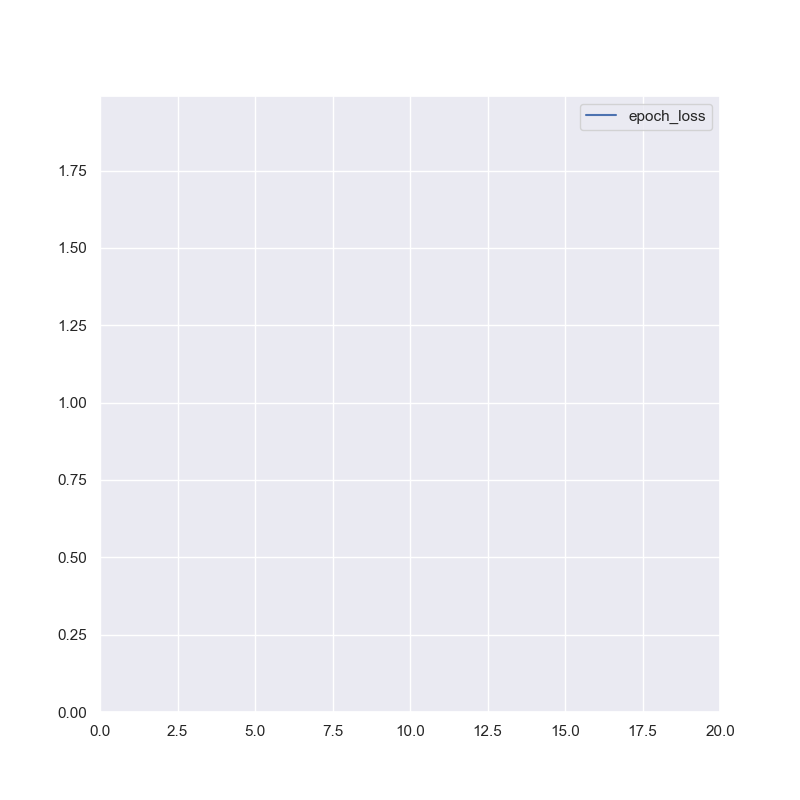

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.997064 [550656/5508407]
loss: 0.979234 [1101312/5508407]
loss: 0.981669 [1651968/5508407]
loss: 0.966386 [2202624/5508407]
loss: 0.953075 [2753280/5508407]
loss: 1.000145 [3303936/5508407]
loss: 0.962209 [3854592/5508407]
loss: 0.961329 [4405248/5508407]
loss: 0.995779 [4955904/5508407]
loss: 1.001691 [5506560/5508407]
Test Error: 
 Accuracy: 49.9%, Avg loss: 0.990947 

Epoch 2
-------------------------------


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/j_hone04/anaconda3/envs/cnn-env/lib/python3.9/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as 

KeyboardInterrupt: 

In [23]:
plt.ion()
run_training(20)